In [4]:
train_images=train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images=(train_images-127.5)/127.5
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [5]:
#构建生成器
def make_generator():
    generator=keras.Sequential([
        keras.layers.Dense(7*7*256,use_bias=False,input_shape=(100,)),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Reshape((7,7,256)),
        keras.layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,
                                     activation='tanh')
    ])
    return generator

2023-08-23 10:47:39.940521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8801


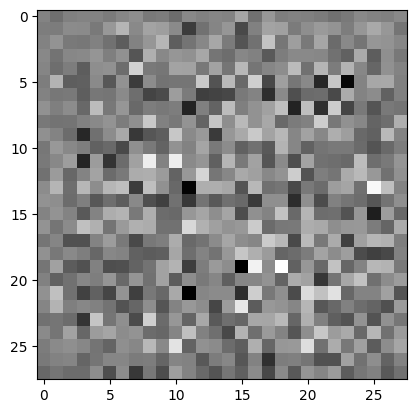

In [6]:
#对生成器进行测试
g=make_generator()
z=tf.random.normal([1,100])
fake_image=g(z,training=False)
plt.imshow(fake_image[0,:,:,0],cmap='gray')
plt.show()

In [7]:
#构建判别器
def make_discriminator():
    discriminator=keras.Sequential([
        keras.layers.Conv2D(64,(5,5),strides=(2,2),padding='same'),
        keras.layers.LeakyReLU(),
        keras.layers.Dropout(0.2),
        keras.layers.Conv2D(128,(5,5),strides=(2,2),padding='same'),
        keras.layers.LeakyReLU(),
        keras.layers.Dropout(0.2),
        keras.layers.Flatten(),
        keras.layers.Dense(1),
    ])
    return discriminator

In [8]:
#对判别器进行测试
g=make_generator()#生成器
z=tf.random.normal([1,100])
fake_image=g(z,training=False)
d=make_discriminator()#判别器
pred=d(fake_image)
print('pred score is :',pred)

pred score is : tf.Tensor([[-0.00178258]], shape=(1, 1), dtype=float32)


In [9]:
#定义损失函数和优化器
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer=keras.optimizers.Adam(1e-4)
d_optimizer=keras.optimizers.Adam(1e-4)
#定义生成器和判别器的损失函数
def generator_loss(fake_image):
    return cross_entropy(tf.ones_like(fake_image),fake_image)
def discriminator_loss(fake_image,real_image):
    real_loss=cross_entropy(tf.ones_like(real_image),real_image)
    fake_loss=cross_entropy(tf.ones_like(fake_image),fake_image)
    return real_loss+fake_loss

In [10]:
#设置检查点
checkpoint_dir='./training_chekpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,"cpkt")
checkpoint=tf.train.Checkpoint(g_optimizer=g_optimizer,
                               d_optimizer=d_optimizer,g=g,d=d)

In [11]:
#定义大批量数据训练过程，注意此处使用tf.function来加快函数运算
@tf.function
def train_one_step(images):
    z=tf.random.normal([BATCH_SIZE,z_dim])
    with tf.GradientTape() as g_tape,tf.GradientTape() as d_tape:
        fake_images=g(z,training=True)
        real_pred=d(images,training=True)
        fake_pred=d(fake_images,training=True)
        g_loss=generator_loss(fake_images)
        d_loss=discriminator_loss(real_pred,fake_pred)
        
    g_gradients=g_tape.gradient(g_loss,g.trainable_variables)
    d_gradients=d_tape.gradient(d_loss,d.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients,g.trainable_variables))
    d_optimizer.apply_gradients(zip(d_gradients,d.trainable_variables))
#整个数据集训练过程
def train(dataset,epochs):
    for epoch in range(epochs):
        start=time.time()
        for image_batch in dataset:
            train_one_step(image_batch)
        generate_and_save_images(g,epoch+1,seed)
        if(epoch+1)%15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        print('Time of epoch {} is {} sec'.format(epoch+1,time.time()-start))
    generate_and_save_images(g,epochs,seed)
        
#显示图像
def generate_and_save_images(model,epoch,test_input):
    predictions=model(test_input,training=False)
    fig=plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()